In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1gYVKzJiFWSfPQj9O4nfo7GIom_hUqR1A')

     |████████████████████████████████| 71kB 5.0MB/s 


# Imports

In [2]:
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


from PIL import Image
from tqdm import tqdm

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from torchvision.datasets import MNIST

from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions

In [3]:
# move to Device

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else: 
        return torch.device('cpu')

device = get_default_device()
device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)



# Denormalize images
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Visualization
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


def save_samples(index, model, latent_tensors, show=True, verbose=False):
    fake_images = model(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if verbose:
        print('Saving', fake_fname)
    if show:
        show_images(fake_images)

# Constants

In [4]:
BATCH_SIZE=256
LEARNING_RATE = 0.0002
IMAGE_CHANNELS = 1
CAPACITY = 64
LATENT_SIZE = 100
EPOCHS = 100

# Prepare Dataset

In [5]:
dataset = MNIST(root='./data', 
                train=True, 
                download=True,
                transform=T.Compose(
                    [
                     T.ToTensor(),
                     T.Normalize(mean=(0.5,), std=(0.5,))
                    ]
                ))

data_loader = DataLoader(dataset, 
                         BATCH_SIZE,
                         shuffle=True, 
                         pin_memory=True,
                         num_workers=4)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
mnist = DeviceDataLoader(data_loader, device)




Label: 2
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -0.6941],
         [-1.0000, -1.0000, -1.0000, -1.0000,  0.6706],
         [-1.0000, -1.0000, -1.0000, -0.7647,  0.8353],
         [-1.0000, -1.0000, -1.0000,  0.0667,  0.9843],
         [-1.0000, -1.0000, -0.3255,  0.9686,  0.9843]]])


(tensor(-1.), tensor(0.9922))

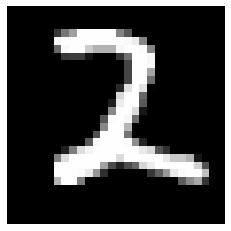

In [7]:
img, label = dataset[torch.randint(50000, (1,), device=device)[0].item()]

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
plt.axis("off")
print('Label:', label)

print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

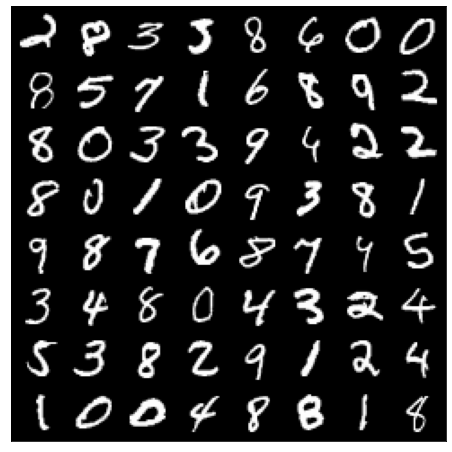

In [8]:
show_batch(mnist)

# Model Design

## Discriminator Network

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=IMAGE_CHANNELS, out_channels=CAPACITY, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(CAPACITY)
        self.conv2 = nn.Conv2d(in_channels=CAPACITY, out_channels=CAPACITY, kernel_size=4, stride=2, padding=1, bias=False)
        self.fc1 = nn.Linear(in_features=3136, out_features=1, bias=False)
        self.leaky_activation = nn.LeakyReLU(0.2, inplace=True)
        self.drop_out = nn.Dropout2d(0.4)

    
    def forward(self, xb):
        xb = self.conv1(xb)        
        xb = self.leaky_activation(xb)
        xb = self.drop_out(xb)
    
        xb = self.conv2(xb)
        xb = self.batch_norm(xb)
        xb = self.leaky_activation(xb)
        
        xb = xb.view(xb.size(0), -1)
        xb = self.fc1(xb)
        xb = torch.sigmoid(xb)
        return xb

In [10]:
summary(to_device(Discriminator(), device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,024
         LeakyReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          65,536
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Linear-7                    [-1, 1]           3,136
Total params: 69,824
Trainable params: 69,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.27
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


## Generator Network

In [11]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc = nn.Linear(in_features=LATENT_SIZE, out_features=128*7*7, bias=False)
        self.conv_transpose_1 = nn.ConvTranspose2d(in_channels=CAPACITY*2, out_channels=CAPACITY*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(CAPACITY*2)
        self.conv_transpose_2 = nn.ConvTranspose2d(in_channels=CAPACITY*2, out_channels=CAPACITY, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(CAPACITY)
        self.relu_activation = nn.ReLU(True)
        self.conv = nn.Conv2d(in_channels=CAPACITY, out_channels=IMAGE_CHANNELS, kernel_size=7, stride=1, padding=3, bias=False)
        # self.conv = nn.Conv2d(in_channels=CAPACITY*2, out_channels=IMAGE_CHANNELS, kernel_size=1, stride=1, bias=False)
        self.tanh_activation = nn.Tanh()


    def forward(self, xb):
        xb = self.fc(xb)
        xb = self.relu_activation(xb)
        xb = xb.view(xb.size(0), 128, 7, 7)
        
        xb = self.conv_transpose_1(xb)
        xb = self.batch_norm_1(xb)
        xb = self.relu_activation(xb)
        
        xb = self.conv_transpose_2(xb)
        xb = self.batch_norm_2(xb)
        xb = self.relu_activation(xb)

        xb = self.conv(xb)

        xb = self.tanh_activation(xb)
        return xb

In [12]:
summary(to_device(Generator(), device), (LATENT_SIZE,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         627,200
              ReLU-2                 [-1, 6272]               0
   ConvTranspose2d-3          [-1, 128, 14, 14]         262,144
       BatchNorm2d-4          [-1, 128, 14, 14]             256
              ReLU-5          [-1, 128, 14, 14]               0
   ConvTranspose2d-6           [-1, 64, 28, 28]         131,072
       BatchNorm2d-7           [-1, 64, 28, 28]             128
              ReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9            [-1, 1, 28, 28]           3,136
             Tanh-10            [-1, 1, 28, 28]               0
Total params: 1,023,936
Trainable params: 1,023,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.83
Params size (MB): 3.91
Estimat

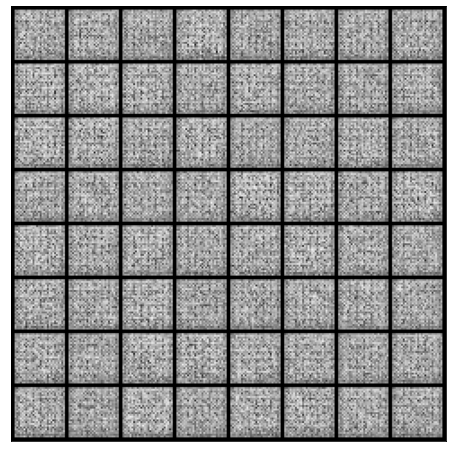

In [13]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, device="cpu") # random latent tensors
fake_images = Generator()(xb)
show_images(fake_images.cpu().detach())

# Training Setup

In [14]:
def training_discriminator(discriminator, generator, real_images, optimizer_d):
    optimizer_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_d.step()
    return loss.item(), real_score, fake_score

In [15]:
def training_generator(discriminator, generator, optimizer_g):

    optimizer_g.zero_grad()

    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    optimizer_g.step()
    
    return loss.item()    

# Training

In [16]:
sample_dir = 'generated'
!rm -rf {sample_dir}

os.makedirs(sample_dir)

In [17]:
# fixed latents for visualizing progress

fixed_latents = torch.randn(64, LATENT_SIZE, device=device)

Saving generated-images-0000.png


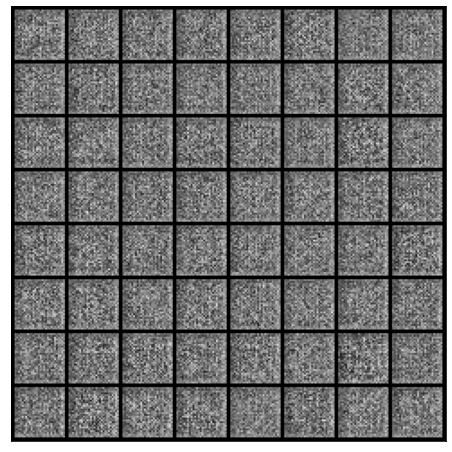

In [18]:
save_samples(0, to_device(Generator(), device), fixed_latents, show=True, verbose=True)

In [20]:
def fit(generator, discriminator, epochs, lr):

    torch.cuda.empty_cache()
    generator_loss = []
    discriminator_loss = []
    generator_score = []
    discriminator_score = []
    
    # create optimizers 
    optimizer_generator = torch.optim.Adam(generator.parameters(),
                                            lr=lr,
                                            betas=(0.5, 0.999))
    
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(),
                                            lr=lr,
                                            betas=(0.5, 0.999))
    for epoch in range(epochs):
        # Losses & scores
        losses_g = []
        losses_d = []
        real_scores = []
        fake_scores = []

        for real_images, _ in mnist:

            # train discriminator 
            
            loss_d, real_score, fake_score = training_discriminator(discriminator, 
                                                                    generator,
                                                                    real_images,
                                                                    optimizer_discriminator)

            # train generator
            loss_g = training_generator(discriminator, 
                                        generator,
                                        optimizer_generator)
            # Record losses & scores
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

        
        losses_g_mean = sum(losses_g)/ len(losses_g)
        losses_d_mean = sum(losses_d)/ len(losses_d)
        real_scores_mean = sum(real_scores)/ len(real_scores)
        fake_scores_mean = sum(fake_scores)/ len(fake_scores)


        generator_loss.append(losses_g_mean)
        discriminator_loss.append(losses_d_mean)
        discriminator_score.append(real_scores_mean)
        generator_score.append(fake_scores_mean)
        

            
        # Log losses & scores (last batch)
        print(f"Epoch [{epoch+1:03}/{epochs}], loss_g: {losses_g_mean:.4f}, loss_d: {losses_d_mean:.4f}, real_score: {real_scores_mean:.4f}, fake_score: {fake_scores_mean:.4f}")
    
        # Save generated images
        with torch.no_grad():
            save_samples(epoch+1, generator, fixed_latents, show=False, verbose=False)
    
    return generator_loss, discriminator_loss, discriminator_score, generator_score

In [22]:
jovian.reset()
jovian.log_hyperparams(lr=LEARNING_RATE, 
                       epochs=EPOCHS,
                       BATCH_SIZE=BATCH_SIZE,
                       channels=CAPACITY,
                       LATENT_SIZE=LATENT_SIZE)

[jovian] Hyperparams logged.


In [23]:
# models
generator_model = Generator()
discriminator_model = Discriminator()

generator_model = to_device(generator_model, device=device)
discriminator_model = to_device(discriminator_model, device=device)

In [24]:
history = fit(generator_model, discriminator_model, EPOCHS, LEARNING_RATE)

Epoch [001/100], loss_g: 0.8867, loss_d: 1.2724, real_score: 0.5469, fake_score: 0.4645
Epoch [002/100], loss_g: 0.8135, loss_d: 1.2782, real_score: 0.5322, fake_score: 0.4654
Epoch [003/100], loss_g: 0.8674, loss_d: 1.2132, real_score: 0.5502, fake_score: 0.4452
Epoch [004/100], loss_g: 0.8319, loss_d: 1.2671, real_score: 0.5384, fake_score: 0.4598
Epoch [005/100], loss_g: 0.8306, loss_d: 1.2673, real_score: 0.5396, fake_score: 0.4597
Epoch [006/100], loss_g: 0.8317, loss_d: 1.2583, real_score: 0.5426, fake_score: 0.4565
Epoch [007/100], loss_g: 0.8347, loss_d: 1.2661, real_score: 0.5411, fake_score: 0.4583
Epoch [008/100], loss_g: 0.8383, loss_d: 1.2610, real_score: 0.5431, fake_score: 0.4565
Epoch [009/100], loss_g: 0.8372, loss_d: 1.2629, real_score: 0.5432, fake_score: 0.4560
Epoch [010/100], loss_g: 0.8326, loss_d: 1.2682, real_score: 0.5421, fake_score: 0.4573
Epoch [011/100], loss_g: 0.8308, loss_d: 1.2714, real_score: 0.5409, fake_score: 0.4584
Epoch [012/100], loss_g: 0.8207,

In [25]:
# log and plot metrics

losses_g, losses_d, real_scores, fake_scores = history

jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


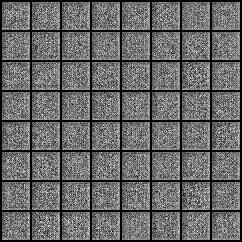

In [26]:
import imageio
from numpy import asarray
import glob
from PIL import Image 

import IPython.display as disp

generated_file = './generation.gif'

filenames = glob.glob('/content/generated/*.png')
filenames = sorted(filenames)
imgs = [asarray(Image.open(img)) for img in filenames]
imageio.mimsave(generated_file, imgs)

with open(generated_file,'rb') as file:
    disp.display(disp.Image(file.read()))

Text(0.5, 1.0, 'Losses')

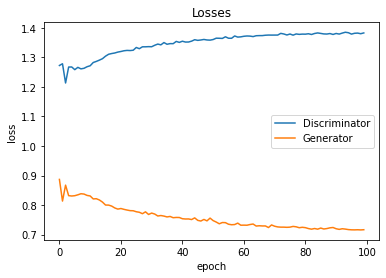

In [27]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

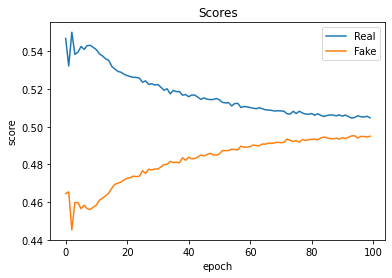

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [29]:
# save model

torch.save(generator_model.to("cpu"), 'generator.pt')
torch.save(discriminator_model.to("cpu"), 'discriminator.pt')

In [30]:
jovian.commit(project="DCGAN_MNIST", 
              outputs=['generator.pt', 'discriminator.pt', 'generation.gif'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/vaibhav-singh-3001/dcgan-mnist


'https://jovian.ai/vaibhav-singh-3001/dcgan-mnist'